In [1]:
# import time
# import os
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
# from astropy.io import fits
# from astropy import units as u
# from astropy.io import fits
# from astropy.coordinates import SkyCoord


In [2]:
# PLOTTING FUNCTIONS

def download_tpf(target_name, sector=None) :
    """
    Given the target name, i.e. 'TIC 233629963', 'TOI 1468', or 'LSPM J1835+3259', downloads the target pixel
    file for the first available sector. If sector keyword is specified (as an integer), that sector only will
    be retrieved. Multisector downloads are not currently supported.
        Input:  target_name - string
                sector - integer of which TESS sector you want
        Output: tpf - a single sector lightkurve TargetPixelFile object 
    """
    if sector :
        return lk.search_targetpixelfile(target_name, sector=sector).download()
    else :
        return lk.search_targetpixelfile(target_name).download()

def plot_pixel_by_pixel(target_name, tpf, plot_type='lc', padding=1, x_lim=None, y_lim=None, save=False, figname=None) :
    """
    Creates a pixel-by-pixel plot of a tess target from the target pixel file. Subplots
    in blue are pixels inside the TESS pipeline aperture and those in red are outside it.
    Note that this code is best used for investigating signals of known duration or period,
    the plots are small so it is very helpful to know your x_lim before plotting. Note that
    this may run slowly, especially if a large aperture or padding is used.
    
    Inputs: target_name - the name of the target to be plotted. Must be resolvable by the TIC.
            plot_type - either 'lc' or 'periodogram'. You may also create a custom function with a bit more work.
            padding - size of the pixel border around the TESS aperture you want to plot. Note
                      that a large padding can result in slow runtime to generate plots.
            x_lim - for 'lc' the BJD dates you want plotted. For 'periodogram' the range of period in days.
            y_lim - the limits of the y-axis. If left blank will be scaled dynamically.
            save - Boolean of whether you would like the plots saved to a file or not.
    """
    def plot_lc(tpf, mask, ax=None, c='b', x_lim=x_lim, y_lim=y_lim) :
        """
        Given a masked target pixel file, calculates the light curve and returns it to be
        plotted in a subplot of the pixel-by-pixel plot.
            Input:  tpf - A target pixel file
                    mask - the associated aperture mask for the tpf
                    ax - the axes object to be plotted into
                    c - the color of the plot
            Output: x, y - arrays to be plotted
        """
        ax = ax or plt.gca()

        # calculate light curve
        lc = tpf.to_lightcurve(aperture_mask=mask.astype(bool)).flatten()
        # bin_lc = lc.flatten(window_length=801).remove_outliers().bin(binsize=5)

        # do the plotting
        ax.plot(lc.time,lc.flux, linestyle='', marker='.', c=c)

        # set x axis window (currently in days)
        if x_lim :
            ax.set_xlim(x_lim)
        else :
            x_lim = [lc.time[0], lc.time[-1]]
            ax.set_xlim(x_lim)
        
        # set y axis window
        x_mask = np.where((lc.time > x_lim[0]) & (lc.time < x_lim[1]))
        if y_lim :
            ax.set_ylim(y_lim)
        else :
            ax.set_ylim([np.nanpercentile(lc.flux[x_mask], 3) * 0.8, np.nanpercentile(lc.flux[x_mask], 97) * 1.2])

        return ax

    def plot_periodogram(tpf, mask, ax=None, c='b', x_lim=x_lim, y_lim=y_lim):
        """
        Given a masked target pixel file, calculates the periodogram and returns it to be
        plotted in a subplot of the pixel-by-pixel plot.
            Input:  tpf - A target pixel file
                    mask - the associated aperture mask for the tpf
                    ax - the axes object to be plotted into
                    c - the color of the plot
                    Output: x, y - arrays to be plotted
        """    
        ax = ax or plt.gca()

        # calculate periodogram
        lc = tpf.to_lightcurve(aperture_mask=mask.astype(bool)).flatten()
        periodogram = lc.to_periodogram()
        periodogram.default_view='period'

        # plot
        line = ax.plot(periodogram.period, periodogram.power, c=c)

        # set x axis window (currently in days)
        if x_lim :
            ax.set_xlim(x_lim)
        else :
            x_lim = [.1,10]
            ax.set_xlim(x_lim)

        # fix the scaling of the y-axis
        if y_lim :
            ax.set_ylim(y_lim)
        else : 
            y_window = np.where((np.array(periodogram.period) < x_lim[1]) & (np.array(periodogram.period) > x_lim[0]))[0]
            max_power = np.max(np.array(periodogram.power)[y_window])
            y_lim = [0, max_power*1.2]
            ax.set_ylim(y_lim)

        return line

    # feel free to add in whatever plotting function you like here
    def plot_custom(tpf, mask, ax=None, c='b', x_lim=x_lim, y_lim=y_lim) :
        """
        To be populated by user.
        Given a masked target pixel file, calculates a custom plot and returns it to be
        plotted in a subplot of the pixel-by-pixel plot.
            Input:  tpf - A target pixel file
                    mask - the associated aperture mask for the tpf
                    Output: x, y - arrays to be plotted
        """
        ax = ax or plt.gca()
        # do what you will with the tpf
        return

    
    # Make plot of the TESS pipeline aperture
    tess_fig = tpf.plot(aperture_mask=tpf.pipeline_mask)
    if save :
        plot_name = target_name + '_tpf_figure'
        plt.savefig(plot_name, facecolor=tess_fig.get_facecolor(), edgecolor='none')
    else :
        plt.show()
        
    # Check that the provided x_lim values are in range. If not, fix them.
    if plot_type == 'lc' :
        if not x_lim :
            x_lim = [tpf.time[0], tpf.time[-1]]
        if x_lim[0] < tpf.time[0] :
            print('x_lim should be provided in BJD - 2457000 (BTJD). The valid date range for this system is ' + str([tpf[0].time, tpf[-1].time]) + '.')
            x_lim[0] = tpf.time[0]
        if x_lim[1] > tpf.time[-1] :
            print('x_lim should be provided in BJD - 2457000 (BTJD). The valid date range for this system is ' + str([tpf[0].time, tpf[-1].time]) + '.')
            x_lim[1] = tpf.time[-1]
    elif plot_type == 'periodogram' :
        if not x_lim :
            print('x_lim for periodograms should be provided as a [min_period, max_period] in units of days.')
            x_lim = [.1, 8]
        elif x_lim[0] < 0 :
            print('x_lim for periodograms should be provided as a [min_period, max_period] in units of days.')
            xlim[0] = 0

    
    # Create our custom mask
    pipe_mask = tpf.pipeline_mask

    # This grabs the dimensions of the existing pipeline mask
    startrow = np.where(np.sum(pipe_mask, axis=1) > 0)[0][0]
    endrow = np.where(np.sum(pipe_mask, axis=1) > 0)[0][-1] + 1
    startcol = np.where(np.sum(pipe_mask, axis=0) > 0)[0][0]
    endcol = np.where(np.sum(pipe_mask, axis=0) > 0)[0][-1] + 1

    # Get the dimensions of an aperature of the size of the pipeline mask 
    # with extra padding around it
    # (abbr for e.g. "start row expanded")
    if (startrow - padding > 0): sre = startrow - padding
    else: sre = 0
    if (startcol - padding > 0): sce = startcol - padding
    else: sce = 0
    if (endrow + padding < tpf.shape[1:][0]): ere = endrow + padding
    else: ere = tpf.shape[1:][0]
    if (endcol + padding < tpf.shape[1:][1]): ece = endcol + padding
    else: ece = tpf.shape[1:][1]

    # create custom mask
    custom_apt = np.zeros(tpf.shape[1:], dtype=np.int)
    custom_apt[sre:ere, sce:ece] = 1

    # set up the subplots
    fig, axs = plt.subplots(ere-sre, ece-sce, figsize=[18,15])
    plt.tight_layout()

    # add overall axes labels
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    if figname :
        plt.title(figname, fontsize=26)
    else: 
        plt.title(target_name, fontsize=26)

    # set the plot function and label axes correctly.
    if plot_type == 'lc' :
        plot_function = plot_lc
        plt.xlabel("Time (BJD)",fontsize=18)
        plt.ylabel("Normalized Flux",fontsize=18)

    elif plot_type == 'periodogram' :
        plot_function = plot_periodogram
        plt.xlabel("Period (days)",fontsize=18)
        plt.ylabel("LSP Power",fontsize=18)

    else :
        print("Invalid plot type. Try 'lc' or 'periodogram'.")
        

    # loop through each pixel in frame
    for i in range(sre, ere) :
        for j in range(sce,ece) : 
            # make aperture
            apij = np.zeros(tpf.shape[1:], dtype=np.int)
            apij[i][j] = 1

            # plot the line
            # check if it is included in the mask and color accordingly
            if tpf.pipeline_mask[i][j] :
                ax = plot_function(tpf, apij, ax=axs[(ere-i-1), j-sce], c='b')
            else :
                ax = plot_function(tpf, apij, ax=axs[(ere-i-1), j-sce], c='r')

    plt.tight_layout()
    
    if save :
        plot_name = target_name + '_PbP_' + plot_type
        fig.savefig(plot_name, facecolor='white', edgecolor='none')
    else :
        plt.show()
    
    
    




In [3]:
# set paths
general_path = '/Users/raeholcomb/Dropbox/Research/single_systems/'


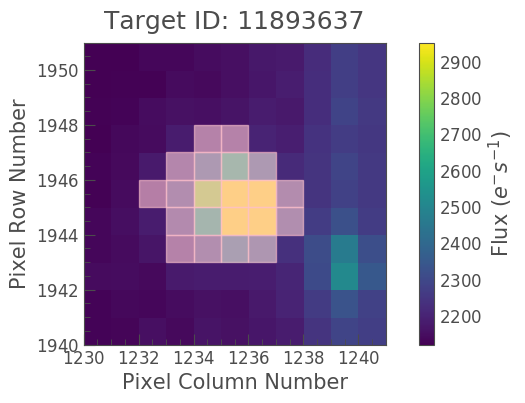

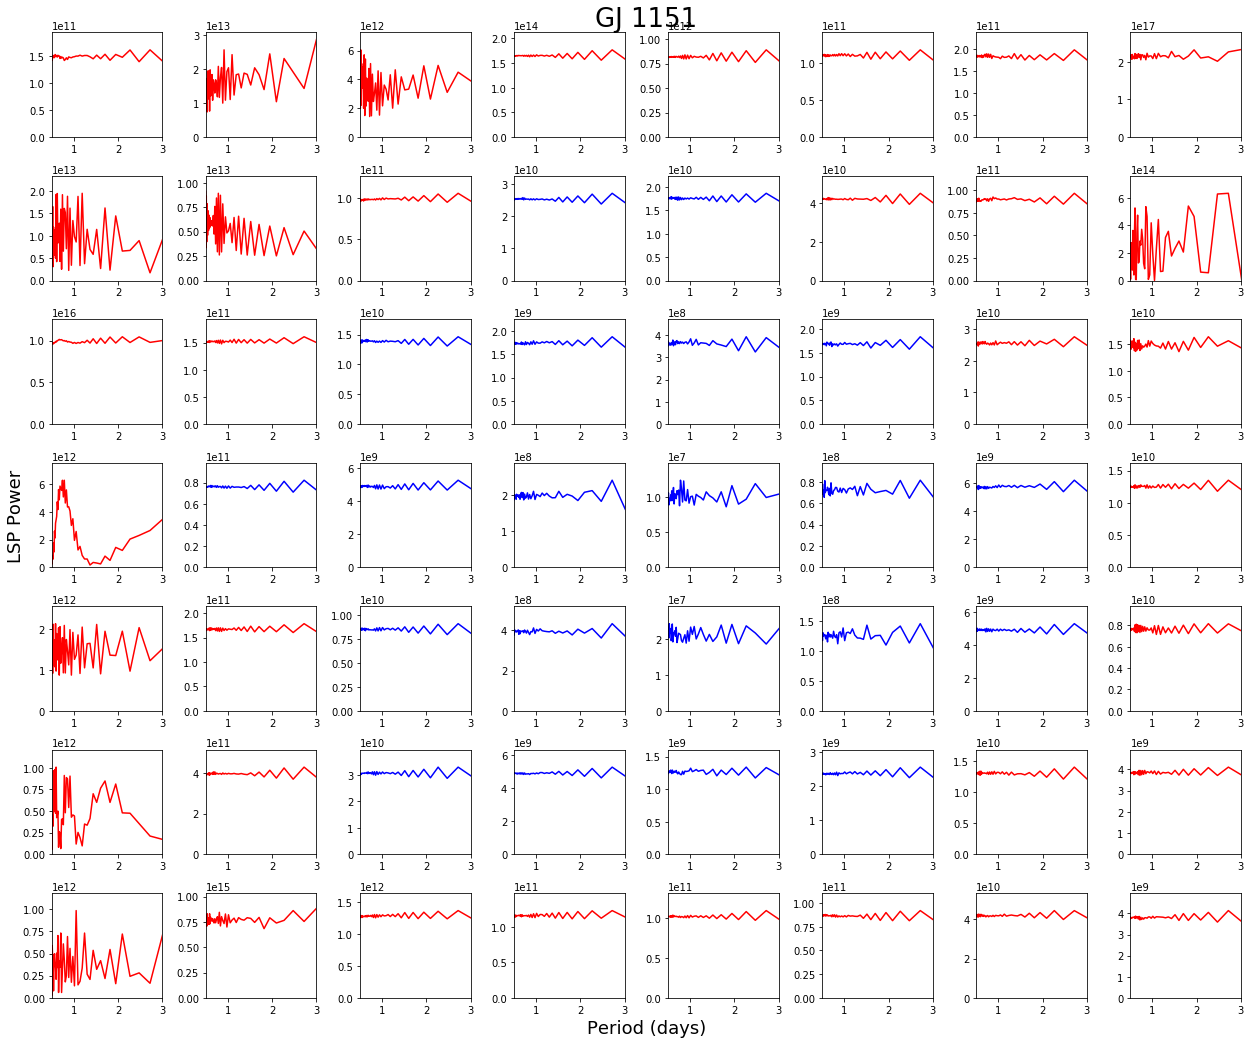

In [7]:
# Set your desired variables

target_name = 'GJ 1151'
padding = 1
# plot_type = 'periodogram'    # options: 'lc' or 'periodogram' or 'custom'
# x_lim = [1987.4, 1987.6]
# x_lim = [.5,8]      # give the limits of the x-axis to be displayed in units of days
# x_lim = [2016.75,2017.5]
x_lim = [0.5,3]

# tpf = download_tpf(target_name)

plot_pixel_by_pixel(target_name, tpf, plot_type='periodogram', padding=1, x_lim=x_lim, save=True)


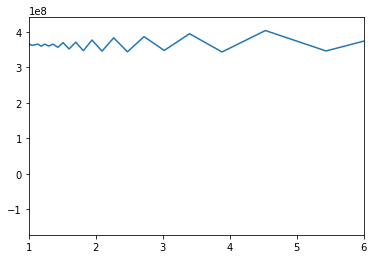

In [10]:
# test out periodogram

lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask).flatten()
periodogram = lc.to_periodogram()
periodogram.default_view='period'

plt.plot(periodogram.period, periodogram.power)
plt.xlim([1,6])
plt.show()

In [11]:
tpf.header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    3 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-07-27'         / file creation date.                            
TSTART  =    2010.269913574756 / observation start time in BTJD                 
TSTOP   =    2035.138256032663 / observation stop time in BTJD                  
DATE-OBS= '2020-06-09T18:27:

In [5]:
# testing other targets
tpf_gj = download_tpf("GJ 251")
print type(tpf_gj)


<class 'lightkurve.targetpixelfile.TessTargetPixelFile'>


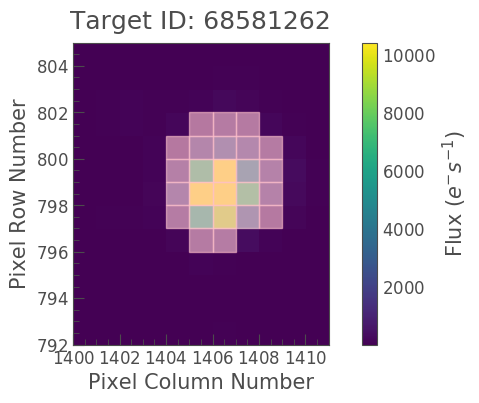

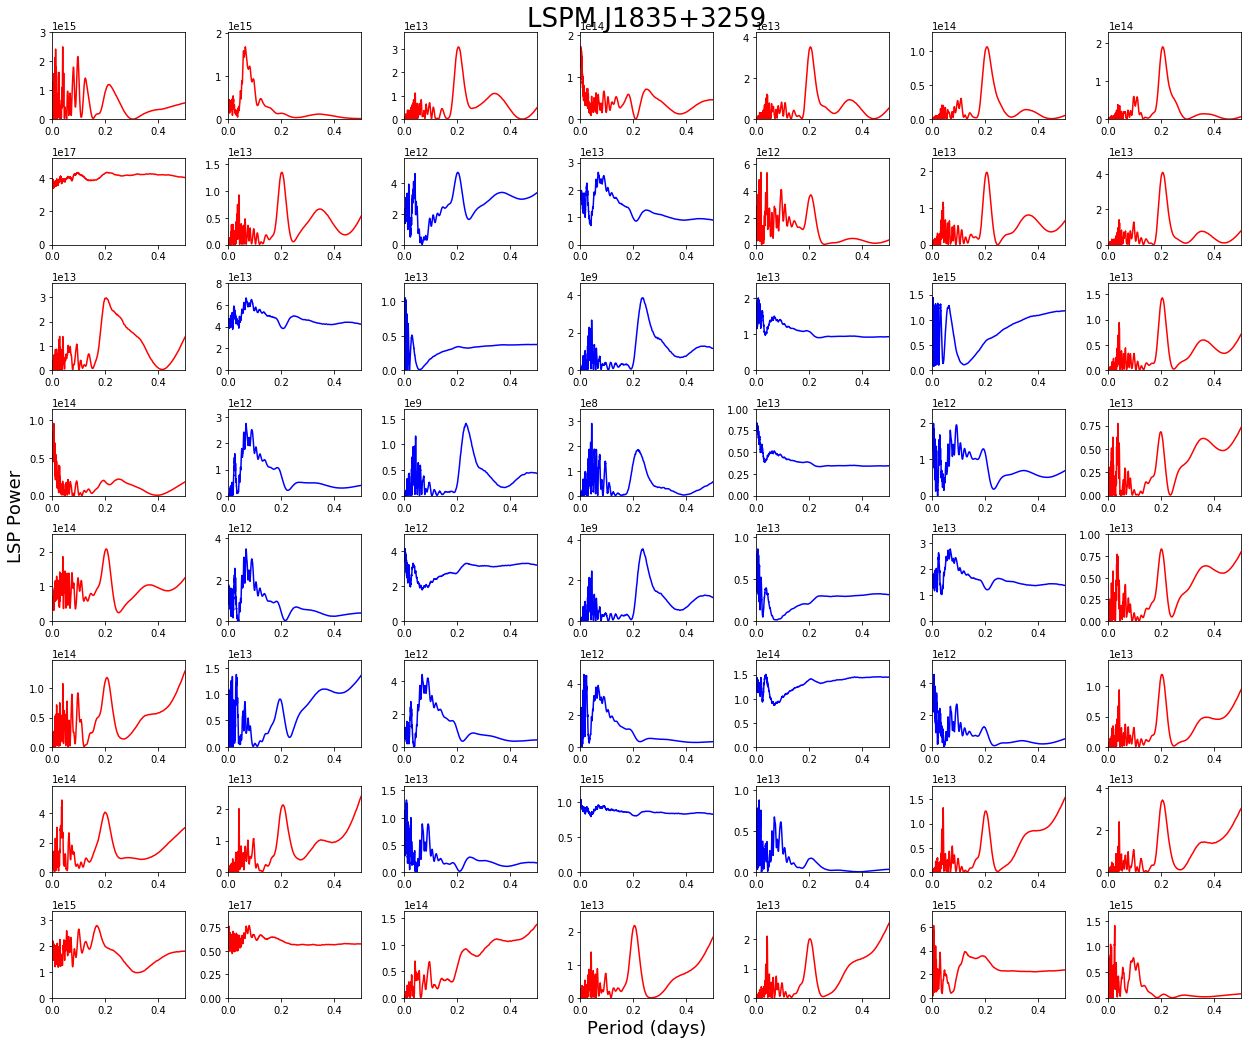

In [27]:
# try to find good x_lim
# lc = tpf_gj.to_lightcurve(aperture_mask=tpf_gj.pipeline_mask.astype(bool)).flatten()
# print lc.time[0], lc.time[-1]

# tpf_gj.time[0]

# plot_pixel_by_pixel(target_name, tpf_gj, plot_type='lc', padding=1, save=False)
plot_pixel_by_pixel(target_name, tpf_gj, plot_type='periodogram', x_lim=[0,.5], padding=1, save=False)



In [ ]:
# Download the Target Pixel File and/or Light Curve File
tpf1 = lk.search_targetpixelfile('TIC 135272255').download()
# tpf = lk.search_targetpixelfile('LSPM J1835+3259').download()
# lcf = lk.search_lightcurvefile('LSPM J1835+3259').download()


In [ ]:
# take a look at what the TPF and pipeline aperture look like
tpf.plot(aperture_mask=tpf.pipeline_mask)

In [ ]:
# Create our custom mask
pipe_mask = tpf.pipeline_mask

# This grabs the dimensions of the existing pipeline mask
startrow = np.where(np.sum(pipe_mask, axis=1) > 0)[0][0]
endrow = np.where(np.sum(pipe_mask, axis=1) > 0)[0][-1] + 1
startcol = np.where(np.sum(pipe_mask, axis=0) > 0)[0][0]
endcol = np.where(np.sum(pipe_mask, axis=0) > 0)[0][-1] + 1

# Get the dimensions of an aperature of the size of the pipeline mask 
# with extra padding around it
# (abbr for e.g. "start row expanded")
if (startrow > 0): sre = startrow - padding
else: sre = 0
if (startcol > 0): sce = startcol - padding
else: sce = 0
if (endrow < tpf.shape[1:][0]): ere = endrow + padding
else: ere = tpf.shape[1:][0]
if (endcol < tpf.shape[1:][1]): ece = endcol + padding
else: ece = tpf.shape[1:][1]

# create custom mask
custom_apt = np.zeros(tpf.shape[1:], dtype=np.int)
custom_apt[sre:ere, sce:ece] = 1


In [ ]:
# start making the pixel by pixel light curves
# print tpf.pipeline_mask

# set up the subplots
fig, axs = plt.subplots(ere-sre, ece-sce, figsize=[18,15])
plt.tight_layout()

# add overall axes labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.title(target_name)

# set the plot function and label axes correctly.
if plot_type == 'lc' :
    plot_function = plot_lc
    plt.xlabel("Time (BJD)",fontsize=18)
    plt.ylabel("Normalized Flux",fontsize=18)

elif plot_type == 'periodogram' :
    plot_function = plot_periodogram
    plt.xlabel("Period (days)",fontsize=18)
    plt.ylabel("LSP Power",fontsize=18)

else :
    print "Invalid plot type. Try 'lc' or 'periodogram'."


# define global plot variables
# plot_type = 'periodogram'
# x_lim = [2016.75,2017.5]
# x_lim = [0.5,4]

# loop through each pixel in frame
for i in range(sre, ere) :
    for j in range(sce,ece) : 
        # make aperture
        apij = np.zeros(tpf.shape[1:], dtype=np.int)
        apij[i][j] = 1

        # plot the line
        # check if it is included in the mask and color accordingly
        if tpf.pipeline_mask[i][j] :
            ax = plot_function(tpf, apij, ax=axs[(i-sre), j-sce], c='b')
        else :
            ax = plot_function(tpf, apij, ax=axs[(i-sre), j-sce], c='r')


plt.tight_layout()
plt.show()
            

# Individual Targets

## TIC 289019393

In [3]:
# TIC 289019393. Two Events.
# Period = 13.0362523700 
# Mid-event time = 2459015.7456559245 (2015.7456559245475)
# Plotted for Caleb Canas on 8/20/2020

target_name = 'TIC 289019393'
tpf_289019393 = download_tpf(target_name)

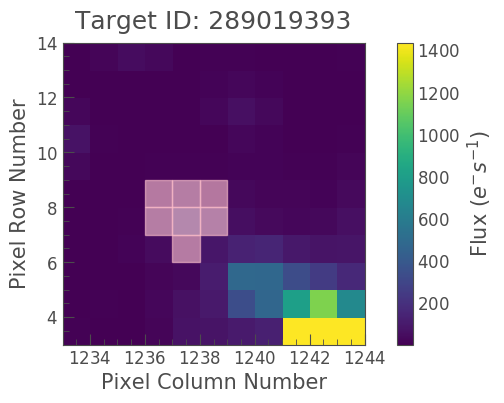

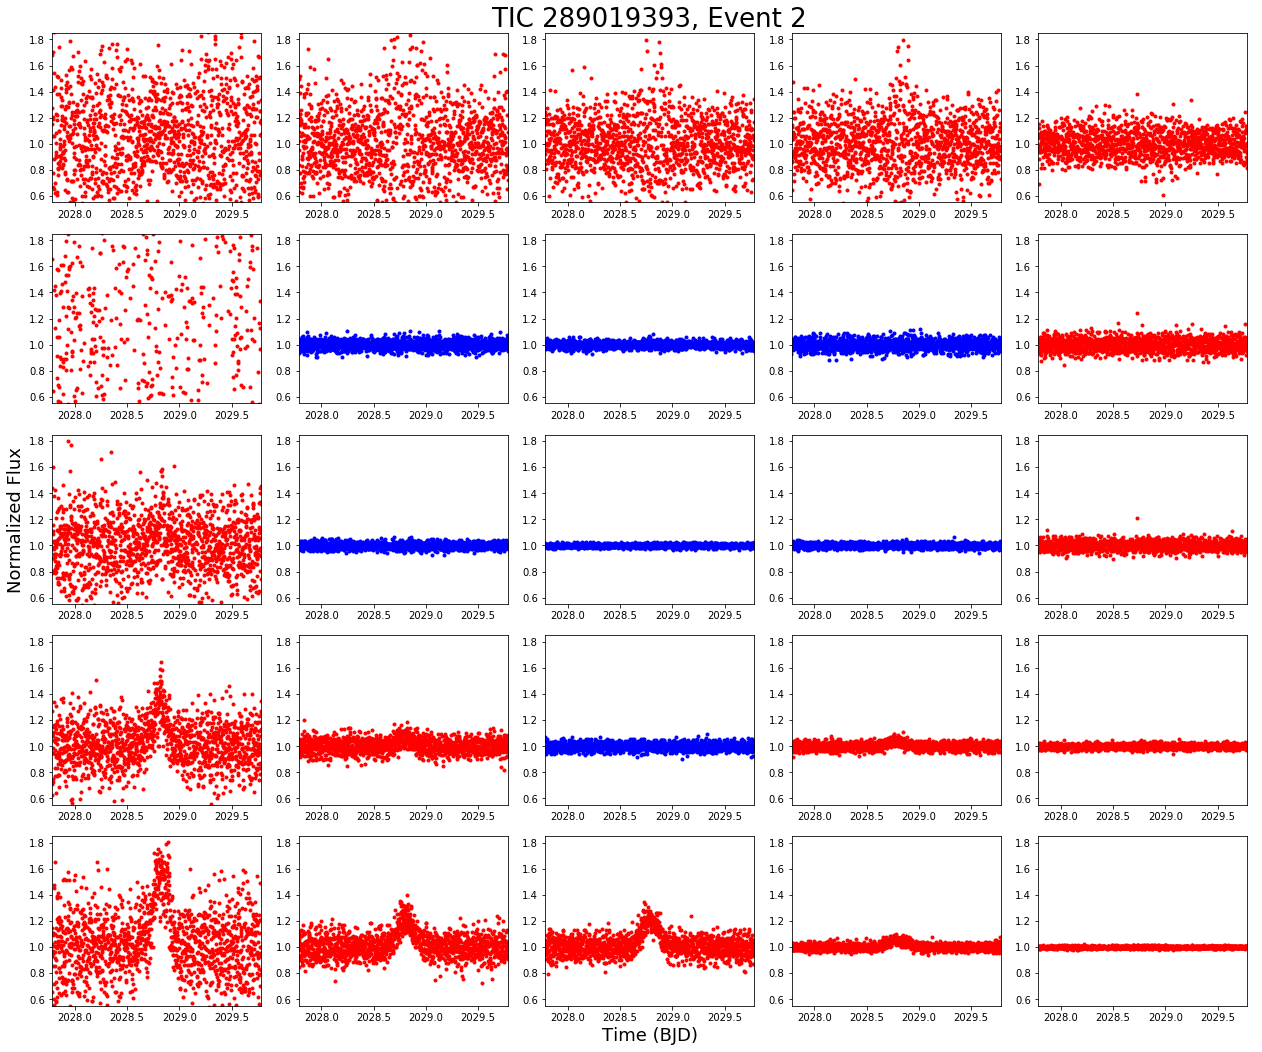

In [17]:
# Event 1, t=2015.7456559245475
mid_time = 2015.7456559245475
period = 13.0362523700
dur = 1

x_lim1 = [mid_time-dur, mid_time+dur]
x_lim2 = [mid_time+period-dur, mid_time+period+dur]
y_lim = [.55, 1.85]
figname1 = target_name + ', Event 1'
figname2 = target_name + ', Event 2'

plot_pixel_by_pixel(target_name, tpf_289019393, plot_type='lc', padding=1, x_lim=x_lim2, y_lim=y_lim, figname=figname2, save=True)


In [52]:
print 2458684.9715 - 2457000

1684.9715


In [45]:
# TIC-233629963. 
# This is seen in Sector 25/26, at a period of 1.5907 days. 
# The mid-transit time is 2458684.9715 (1684.9715)
target_name = 'TIC 233629963'
tpf_233629963 = download_tpf(target_name, sector=26)

x_lim should be provided in BJD - 2457000 (BTJD). The valid date range for this system is [array([2010.26766585]), array([2035.1345821])].


ValueError: Axis limits cannot be NaN or Inf

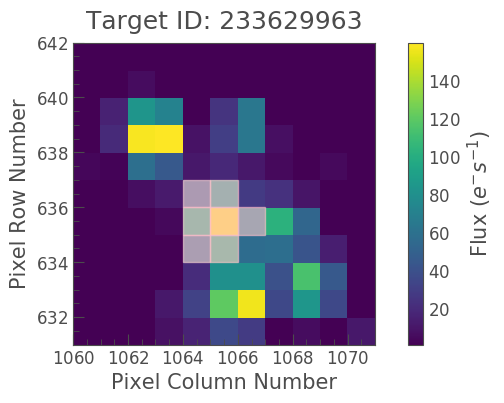

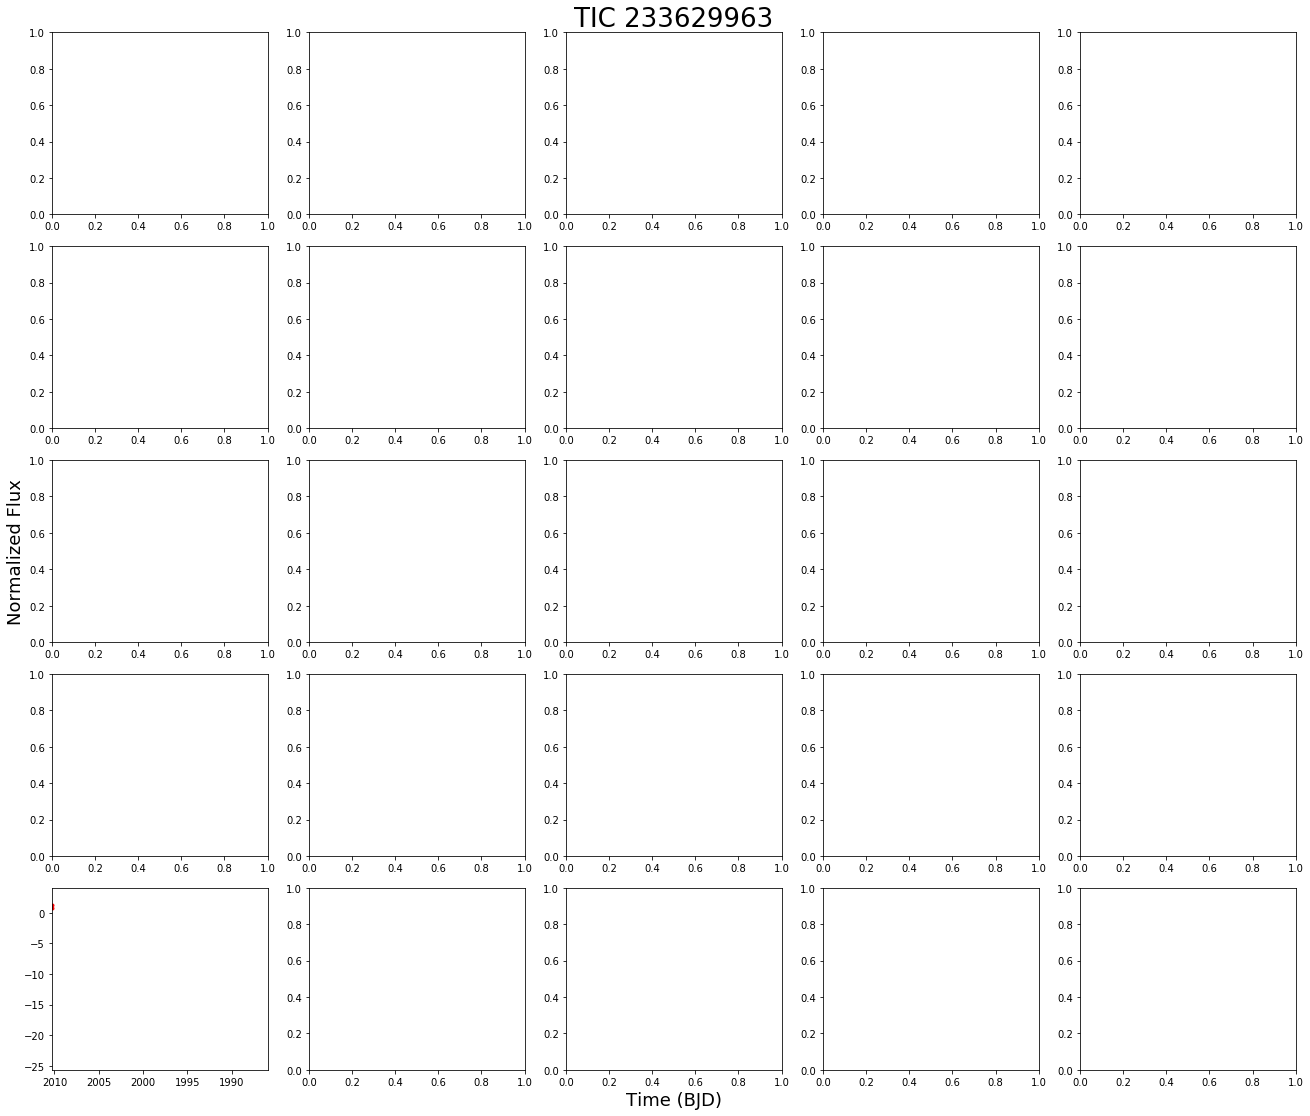

In [49]:
# Event 1, t=2015.7456559245475
mid_time = 1684.97157456559245475
period = 1.5907
dur = 1

x_lim1 = [mid_time-dur, mid_time+dur]
# x_lim2 = [mid_time+period-dur, mid_time+period+dur]
# y_lim = [.55, 1.85]


plot_pixel_by_pixel(target_name, tpf_233629963, plot_type='lc', padding=1, x_lim=x_lim1, save=True)


TOI-1468.01 : TIC 243185500
Mid-event time: 2458766.928101
Period: 15.531925
Duration (hrs): 1.75933
Sectors: 17

TOI-1468.02 : TIC 243185500
Mid-event time: 2458765.678833
Period: 1.880305
Duration (hrs): 1.055416
Sectors: 17


TOI-2015 : 368287008
Mid-event time: 2458956.033366
Period: 3.34589
Duration (hrs): 0.975214
Sectors: 24

TOI-2013 : 188589164
Mid-event time: 2458985.170558
Period: 2.616929
Duration (hrs): 1.01113
Sectors: 25

TOI-2120 : 389900760
Mid-event time: 2458795.822707
Period: 5.79981
Duration (hrs): 0.921501
Sectors: 18, 24, 25

TOI-2136 : 336128819
Mid-event time: 2459017.704899
Period: 7.851706
Duration (hrs): 1.608369
Sectors: 26



In [3]:
tpf_1468 = download_tpf('TOI 1468', sector=17)
tpf_2015 = download_tpf('TOI 2015', sector=24)
tpf_2013 = download_tpf('TOI 2013')
tpf_2120 = download_tpf('TOI 2120')
tpf_2136 = download_tpf('TOI 2136')

/Users/raeholcomb/miniconda2/lib/python2.7/site-packages/lightkurve/search.py:144: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)
/Users/raeholcomb/miniconda2/lib/python2.7/site-packages/lightkurve/search.py:144: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [46]:
print type(tpf_1468)
print tpf_2015.header['Sector']

<class 'lightkurve.targetpixelfile.TessTargetPixelFile'>
24


In [9]:
print 2458766.928101 - 2457000
print tpf_1468.time[0]
print x_lim1
print [mid_time-dur, mid_time+dur]

1766.928101
1764.690027500607
[1764.690027500607, 1766.5]
[1764.5, 1766.5]


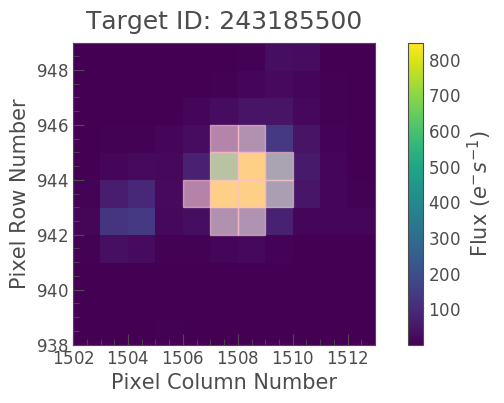

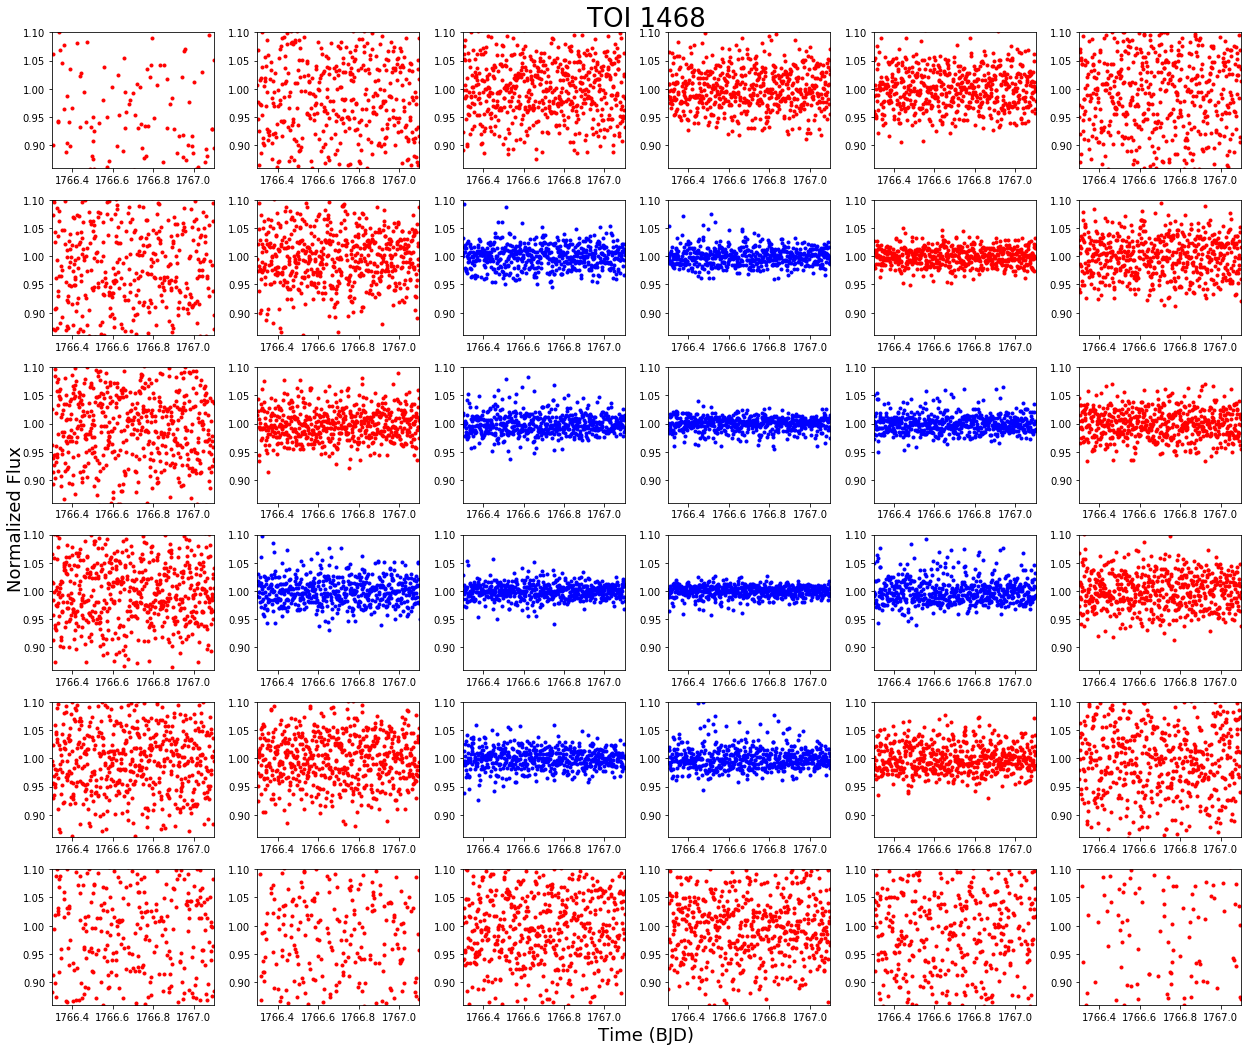

In [11]:
# TOI-1468.01 : TIC 243185500
# Mid-event time: 2458766.928101
# Period: 15.531925
# Duration (hrs): 1.75933
# Sectors: 17
# Mid-event time #2: 2458765.678833
# Period: 1.880305
# Duration (hrs): 1.055416

mid_time = 2458766.928101 - 2457000
mid_time = 1766.7
period = 15.531925
dur = .4

x_lim1 = [mid_time-dur, mid_time+dur]

plot_pixel_by_pixel('TOI 1468', tpf_1468, plot_type='lc', x_lim=x_lim1, y_lim=[.86,1.1], padding=1, save=False)

<function matplotlib.pyplot.show>

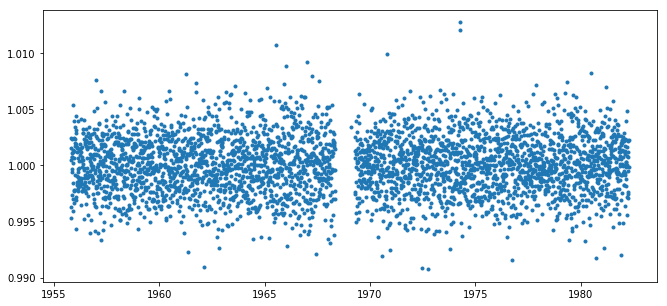

In [14]:
# check the lc
lc = tpf_2015.to_lightcurve(aperture_mask=tpf_2015.pipeline_mask).flatten().bin(binsize=5)
# bin_lc = lc.flatten(window_length=801).remove_outliers().bin(binsize=5)

# print x_lim1

# do the plotting
plt.figure(figsize=[11,5])
plt.plot(lc.time,lc.flux, linestyle='', marker='.')
# plt.xlim([1955.8,1956.3])
plt.show


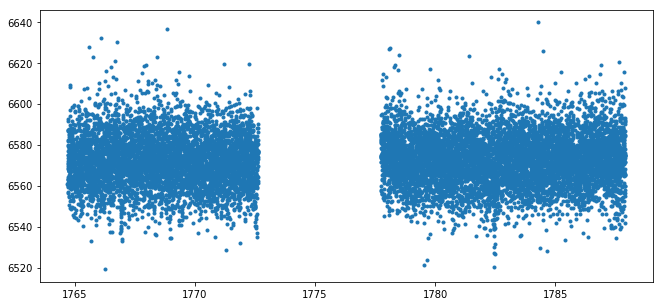

In [19]:
# check toi 1468 against the mast downloaded lcf
lc1468 = lk.search.open(general_path + 'toi_1468_lc.fits').PDCSAP_FLUX

plt.figure(figsize=[11,5])
plt.plot(lc1468.time,lc1468.flux, linestyle='', marker='.')

1956.033366
[2016.75, 2017.5]
1955.7994663498864 1982.284234608986


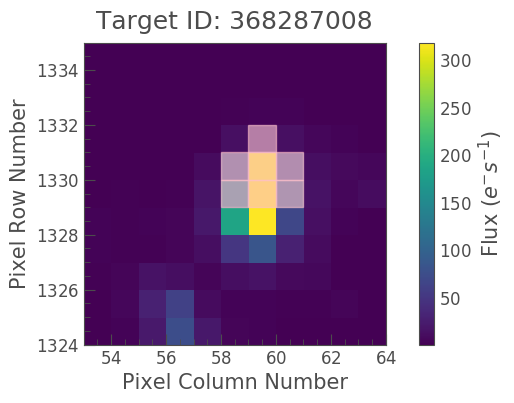

x_lim should be provided in BJD - 2457000 (BTJD). The valid date range for this system is [array([1955.79946635]), array([1982.28423461])].


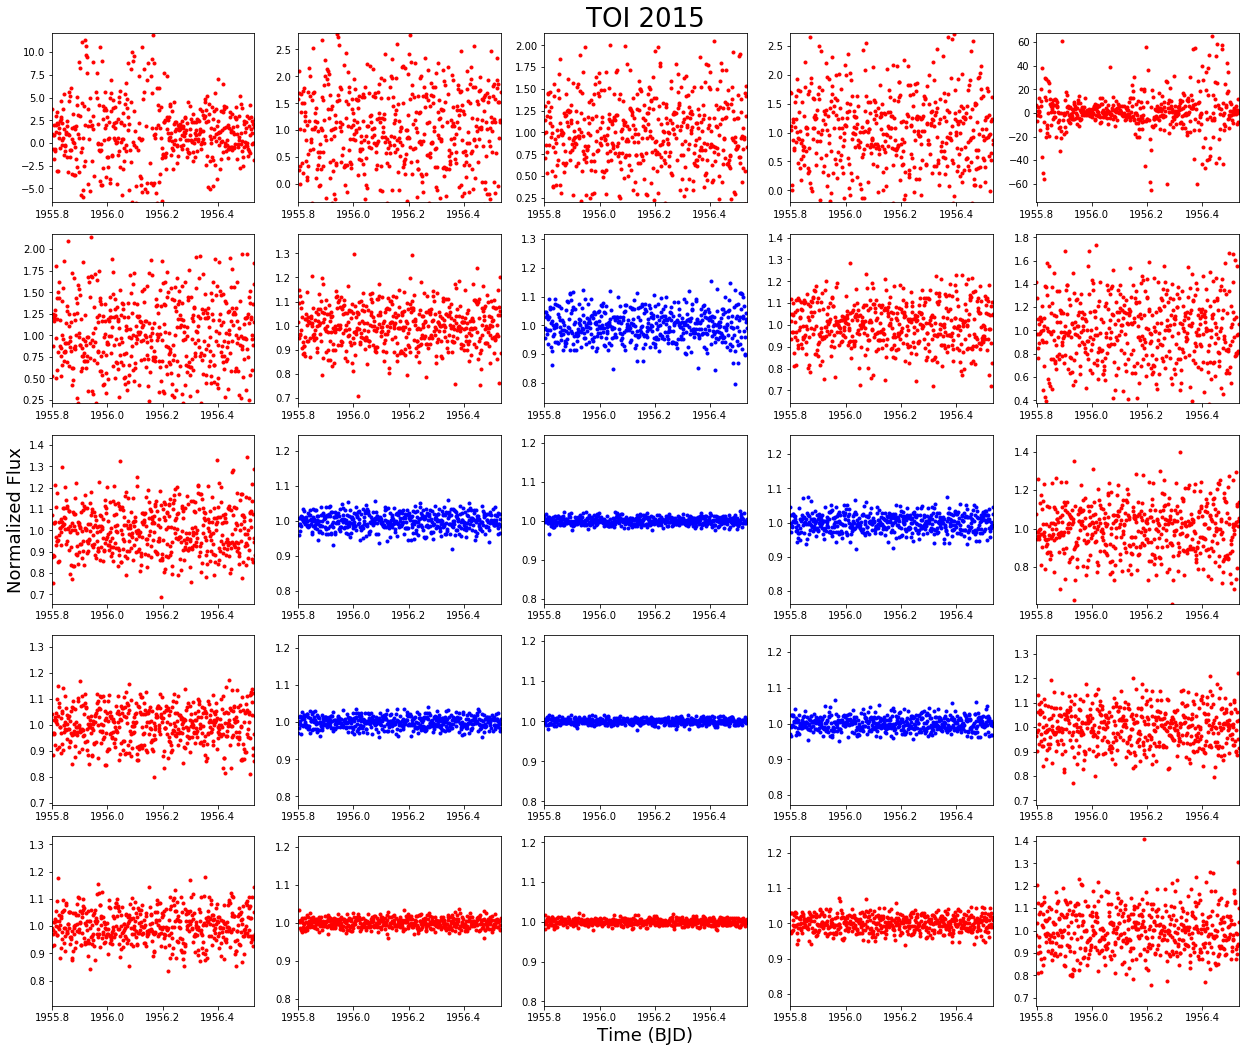

In [42]:
# TOI-2015 : 368287008
# Mid-event time: 2458956.033366
# Period: 3.34589
# Duration (hrs): 0.975214
# Sectors: 24
mid_time = 2458956.033366 - 2457000
period = 3.34589
dur = .5

x_lim1 = [mid_time-dur, mid_time+dur]

# print info
print mid_time
print x_lim
print tpf_2015.time[0], tpf_2015.time[-1]

plot_pixel_by_pixel('TOI 2015', tpf_2015, plot_type='lc', x_lim=x_lim1, padding=1, save=False)

In [ ]:
# REPORT

Hi! Sorry it took me a while to get around to running these but here is what I turned up.

TOI 1468 - Oddly, I couldn't locate any transit events in this light curve. I looked around the midtimes
2458766.928101 and 2458765.678833.
TOI 2015

